In [1]:
import os, fnmatch, cv2
import numpy as np
import matplotlib.pyplot as plt
from models import Noise2Same
os.environ['CUDA_VISIBLE_DEVICES']='1'

### Training

- If you use pre-trained checkpoint files, simply skip this part.

#### Load noisy images and perform normalization.

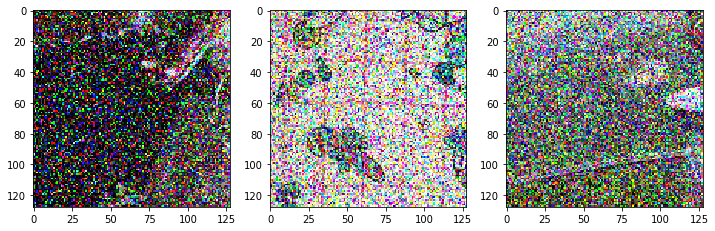

In [2]:
X = np.load('Denoising_data/ImageNet/train.npy')[:,1]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X[0]);
plt.subplot(1,3,2)
plt.imshow(X[1]);
plt.subplot(1,3,3)
plt.imshow(X[2]);

In [3]:
X_norm = np.array([(x - x.mean(axis=(0,1), keepdims=True))/x.std(axis=(0,1), keepdims=True) for x in X])

#### Build denoising model and start training.

In [4]:
model = Noise2Same('trained_models/', 'denoising_ImageNet', dim=2, in_channels=3)

In [5]:
model.train(X_norm.astype('float32'), patch_size=[64, 64], validation=None, batch_size=64, steps=50000)

### Testing/Evaluation

#### Load testing data and perform evaluation.

In [6]:
path = 'Denoising_data/ImageNet/test/'
test_nlst = os.listdir(path)
test = [np.load(path+test_n) for test_n in test_nlst]
test_gt = [t[0] for t in test]
test = [t[1] for t in test]

def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)
def norm(x):
    x = (x-x.min())/(x.max()-x.min())
    return x

In [7]:
preds = [model.predict(t.astype('float32'), im_mean=t.mean(axis=(0,1)).astype('float32'), im_std=t.std(axis=(0,1)).astype('float32')) for t in test]

In [8]:
psnrs = [PSNR(norm(p)*255.0, gt) for p, gt in zip(preds, test_gt)]
np.mean(psnrs)

22.501010561505485

#### Visualizations

In the first row are the input noisy images, and in the second row are the denoised imags.

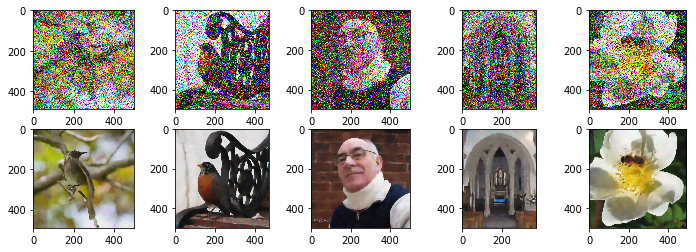

In [10]:
plt.figure(figsize=(12,4))
for i in range(5):
    idx = np.random.randint(len(test))
    plt.subplot(2,5,i+1)
    plt.imshow(test[idx]);
    plt.subplot(2,5,i+6)
    plt.imshow(norm(preds[idx]));